In [1]:
from fastai.vision.all import *

/Users/lucasvanwalstijn/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Convolutions

In [281]:
# 3x3 kernel with 1 input channel and 2 output channels
conv1 = torch.nn.Conv2d(1, 2, (3,3))
conv1

Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))

In [282]:
# let's create some data: batch of 1, 1 image channel, images of size 24x24
x = torch.randn(size=(1, 1, 24, 24))

In [283]:
# output: batch of 1, with now 2 channels and size is 22x22
conv1(x).shape

torch.Size([1, 2, 22, 22])

In [284]:
# We can also create a Conv2d with padding 1 ("same" convolution) so that the output image has the same size as input image

conv_same = torch.nn.Conv2d(1, 2, (3,3), padding=1)
conv_same(x).shape

torch.Size([1, 2, 24, 24])

In [285]:
# We can also do it functionally, by passing in the input, conv weight and conv bias: the result is the same
o1 = torch.conv2d(x, conv1.weight, conv1.bias) 
o2 = conv1(x)

assert torch.allclose(o1,o2)

In [7]:
# And do the same for the conv_same one, then we have to specifiy the padding to torch.conv2d()
o1 = torch.conv2d(x, conv_same.weight, conv_same.bias, padding=1)
o2 = conv_same(x)

assert torch.allclose(o1,o2)

### Let's create a second layer

In [8]:
# This layer now needs to have 2 input channels, and let's create 1 single output channel
conv1 = torch.nn.Conv2d(1, 2, (3,3), padding=1)
conv2 = torch.nn.Conv2d(2, 1, (3,3), padding=1)

o1 = F.relu(conv1(x)) # Also add a Relu in between the convs
o2 = conv2(o1)

print(f'{o1.shape=}', f'{o2.shape=}', sep='\n') 

o1.shape=torch.Size([1, 2, 24, 24])
o2.shape=torch.Size([1, 1, 24, 24])


### And let's also do it manually:

In [9]:
o1_c1 = o1[:,[0],:,:] # output1 channel 1
o1_c2 = o1[:,[1],:,:] # output1 channel 2
o1_c1.shape, o1_c2.shape

(torch.Size([1, 1, 24, 24]), torch.Size([1, 1, 24, 24]))

In [10]:
o2_c1 = torch.conv2d(o1_c1, conv2.weight[:,[0],:, :], padding=1) # the 2nd conv on the first channel
o2_c2 = torch.conv2d(o1_c2, conv2.weight[:,[1],:, :], padding=1) # the 2nd conv on the second channel

o2_manual = o2_c1 + o2_c2 + conv2.bias # add together + the bias

In [22]:
assert torch.allclose(o2_manual, o2)

What this should show, is that it should be clear that each channel (in this case 2) gets multiplied with it's own kernel. The results are then added. So if we have a 3 channel input image, the first convolution comprises of 3 kernels of size (x,x), each channel gets multiplied by its own kernel, and the results are added together. Moreover, if we have 6 output channels, that means that for for each output channel we will have 3 kernels which get multiplied by the inputs and are then added.

### Max Pooling

In [276]:
mp = torch.nn.MaxPool2d((2,2))

In [277]:
o2.shape, mp(o2).shape

(torch.Size([1, 1, 24, 24]), torch.Size([1, 1, 12, 12]))

The shape of the image is halved as expected, let's check that the values also make sense:

In [14]:
o2[0,0,0:2,0:2]

tensor([[0.1650, 0.1650],
        [0.2039, 0.2006]], grad_fn=<SliceBackward0>)

In [15]:
o3 = mp(o2)

o3[0,0,0,0]

tensor(0.2039, grad_fn=<SelectBackward0>)

In [16]:
assert torch.allclose(o2[0,0,0:2,0:2].max(), o3[0,0,0,0])

And another block:

In [17]:
o2[0,0,2:4,2:4]

tensor([[0.1094, 0.1263],
        [0.1466, 0.1022]], grad_fn=<SliceBackward0>)

In [18]:
o3[0,0,1,1]

tensor(0.1466, grad_fn=<SelectBackward0>)

In [19]:
assert torch.allclose(o2[0,0,2:4,2:4].max(), o3[0,0,1,1])

### Fully connected layer

In [20]:
# Now we want to add a FC layer, which need to have the shape of [image_size x image_size, x], let's take x=1 so that we output one single value

fc = torch.nn.Linear(12*12, 1)

In [21]:
# But we can't just connect it to our o3:

fc(o3)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (12x12 and 144x1)

In [23]:
# So we need to flatten the output of our max pooling layer into 12x12 -> 144

# Manually:
o3_f1 = o3.view(-1)

# With torch method
o3_f2 = torch.flatten(o3)

# With torch layer
t_F = torch.nn.Flatten()
o3_f3 = t_F(o3)

# With FasAI:
f_F = Flatten()
o3_f4 = f_F(o3)

assert torch.allclose(o3_f1, o3_f2)
assert torch.allclose(o3_f2, o3_f3)
assert torch.allclose(o3_f3, o3_f4)

#### But there is a caveat here:

In [24]:
print(f'{o3_f1.shape=}', f'{o3_f2.shape=}', f'{o3_f3.shape=}', f'{o3_f4.shape=}', sep='\n')

o3_f1.shape=torch.Size([144])
o3_f2.shape=torch.Size([144])
o3_f3.shape=torch.Size([1, 144])
o3_f4.shape=torch.Size([1, 144])


So `view(-1)` and `torch.flatten` flatten the input "completely", whereas the torch and FastAI objects don't: they keep the shape of the first dimension. They do this because generally the very first dimension consists of the batches, and we don't want to flatten them out since they represent the multiple samples we are feeding through the network.

However we can also do:

In [25]:
# With torch layer
t_F_f = torch.nn.Flatten(start_dim=0) # start_dim=1 by default
o3_f5 = t_F_f(o3)

# With FasAI:
f_F_f = Flatten(full=True)
o3_f6 = f_F_f(o3)

print(f'{o3_f5.shape=}', f'{o3_f6.shape=}', sep='\n')

o3_f5.shape=torch.Size([144])
o3_f6.shape=torch.Size([144])


In [26]:
# And now we can apply the linear layer:

fc(o3_f6)

TensorBase([-0.3135], grad_fn=<AliasBackward0>)

In [32]:
# And we can do the same all at once:

fc(f_F_f(mp(conv2(F.relu(conv1(x))))))

TensorBase([-0.3135], grad_fn=<AliasBackward0>)

### Do it all at once

In [33]:
combined = nn.Sequential(
    # input shape: [1, 1, 24, 24]
    conv1, # 1,2,(3,3)
    torch.nn.ReLU(),
    # activations shape: [1, 2, 24, 24]
    conv2, # 2,1,(3,3)
    # activations shape: [1, 1, 24, 24]
    mp, # kernel: (2,2)
    # activations shape: [1, 1, 12, 12]
    torch.nn.Flatten(start_dim=0),
    # activations shape: [1, 144]
    fc # [144, 1]
    # activations shape: [1, 1]
)

In [34]:
combined(x)

tensor([-0.3135], grad_fn=<AddBackward0>)

### And it's exactly the same result

In [35]:
combined

Sequential(
  (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=0, end_dim=-1)
  (5): Linear(in_features=144, out_features=1, bias=True)
)

### Continue with some actual data

In [61]:
path = untar_data(URLs.MNIST_SAMPLE)

In [62]:
(path).ls()

(#3) [Path('/Users/lucasvanwalstijn/.fastai/data/mnist_sample/valid'),Path('/Users/lucasvanwalstijn/.fastai/data/mnist_sample/labels.csv'),Path('/Users/lucasvanwalstijn/.fastai/data/mnist_sample/train')]

In [73]:
dblock = DataBlock(
    blocks=[ImageBlock(cls=PILImageBW), CategoryBlock],
    get_items=get_image_files,
    splitter=GrandparentSplitter('train','valid'),
    get_y=parent_label,
    batch_tfms=Normalize()
)

In [74]:
dls = dblock.dataloaders(path, bs=64)

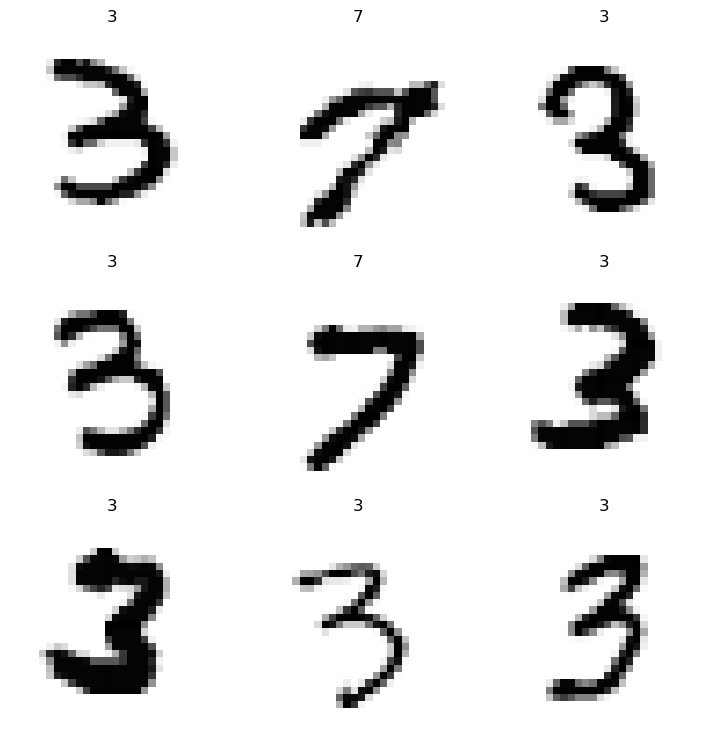

In [75]:
dls.show_batch()

In [76]:
xb, yb = dls.one_batch()
xb.shape

torch.Size([64, 1, 28, 28])

In [243]:
def conv(in_c, out_c, ks=3, act=True, *args):
    c = nn.Conv2d(in_c, out_c, ks, stride=2, padding=ks//2)
    if act: return nn.Sequential(c, nn.ReLU())
    return nn.Sequential(c)
    

simple_cnn = nn.Sequential(
    # input: [64, 1, 28, 28]
    conv(1, 4), 
    # activations: [64, 4, 14, 14]
    conv(4, 8),
    # activations: [64, 8, 7, 7]
    conv(8, 16),
    # activations: [64, 16, 4, 4]
    conv(16, 32),
    # activations: [64, 32, 2, 2]
    conv(32, 2, act=False),
    # activations: [64, 2, 1, 1]
    Flatten()
    # activations: [64, 2]
)

In [244]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [245]:
learn = Learner(dls, simple_cnn, cbs=ActivationStats(with_hist=True))

In [246]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [247]:
# So in the first layer we are having 3*3 = 9 pixels, that are being used to compute 4 pixels (c_out). 
# In the second layer, we are using 3*3*4 = 36 pixels, that are being used to compute 16 pixels
# In the third layer, we are using 3*3*8 = 72 pixels, that are being used to compute 32 pixels
# That is looking quite good

In [248]:
# We thus can't further increase the amount of features in the first layer, if we would go to 8:
# So in the first layer we are having 3*3 = 9 pixels, that are being used to compute 8 pixels (c_out), which is not learning but just passing the values

In [249]:
# Somehow we are thus moving from pixel space -> feature space. Each time reducing the size of the image, but increasing the amount of channels / features
# We can do this until all our information is in the channel / features space and we have no more pixels to learn from

In [250]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): fastai.layers.Flatten(full=False)
)

SuggestedLRs(valley=0.001737800776027143)

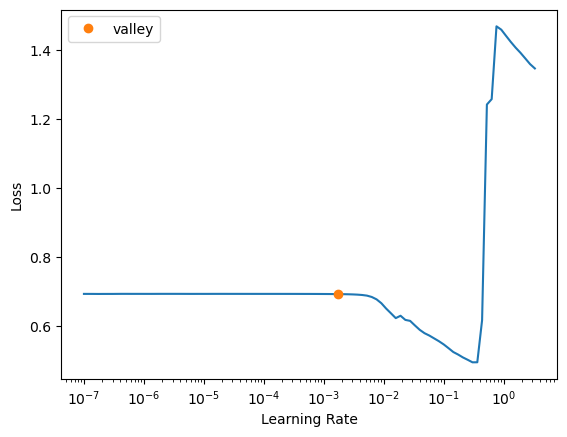

In [251]:
learn.lr_find()

In [252]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.109190,0.056216,00:14
1,0.040714,0.037135,00:15
2,0.025292,0.018846,00:17
3,0.018684,0.024953,00:16
4,0.014878,0.019451,00:16
5,0.010095,0.022907,00:15
6,0.003940,0.019102,00:16
7,0.001080,0.016523,00:15
8,0.000205,0.020795,00:16
9,0.000108,0.021080,00:16


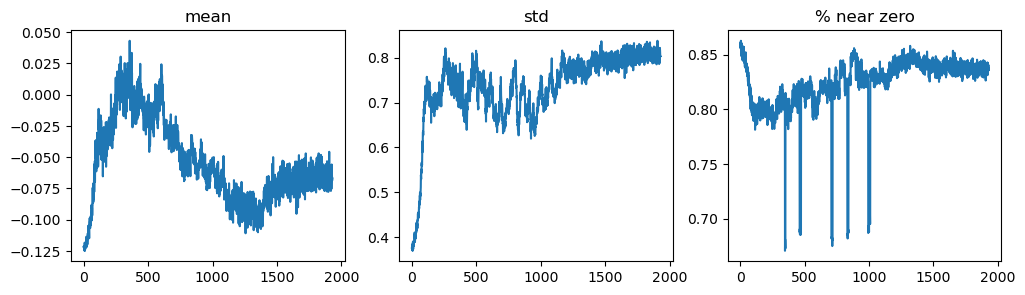

In [253]:
learn.activation_stats.plot_layer_stats(0)

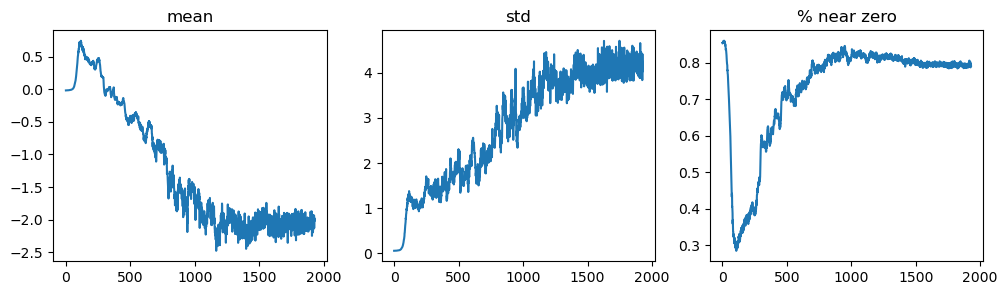

In [254]:
learn.activation_stats.plot_layer_stats(-2)

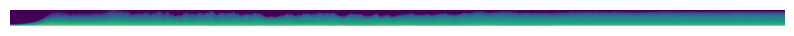

In [255]:
learn.activation_stats.color_dim(1)

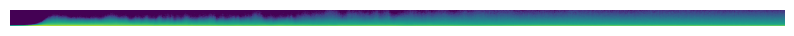

In [256]:
learn.activation_stats.color_dim(2)

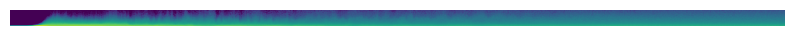

In [257]:
learn.activation_stats.color_dim(3)

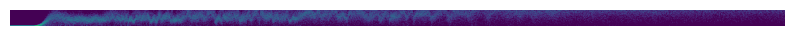

In [258]:
learn.activation_stats.color_dim(4)

### For whatever reason the activations in the latest layer are not sorted..

It should be like this

(-0.5, 1929.5, -0.5, 39.5)

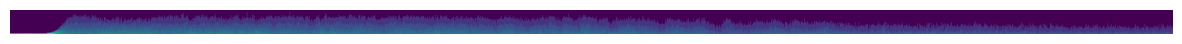

In [260]:
ax = subplots(figsize=(15,5))[1][0]
ax.imshow(learn.activation_stats.hist(4).sort(dim=0, descending=True)[0], origin='lower')
ax.axis('off')

These plots go from blue (low) to yellow (high), you can get the raw data by:

In [225]:
learn.activation_stats.hist(4).shape

torch.Size([40, 1930])

So for 193 batches going from left to right, we have 40 bins of activations. When activation is RELU, then blue means 0..

In [271]:
def conv(in_c, out_c, ks=3, act=True, *args):
    layers = []
    layers.append(nn.Conv2d(in_c, out_c, ks, stride=2, padding=ks//2))
    layers.append(nn.BatchNorm2d(out_c))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)
    

cnn_bn = nn.Sequential(
    # input: [64, 1, 28, 28]
    conv(1, 4), 
    # activations: [64, 4, 14, 14]
    conv(4, 8),
    # activations: [64, 8, 7, 7]
    conv(8, 16),
    # activations: [64, 16, 4, 4]
    conv(16, 32),
    # activations: [64, 32, 2, 2]
    conv(32, 2, act=False),
    # activations: [64, 2, 1, 1]
    Flatten()
    # activations: [64, 2]
)

In [272]:
learn = Learner(dls, cnn_bn, cbs=ActivationStats(with_hist=True))

In [273]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.067705,0.055202,00:14
